
Random Forest Model:
Accuracy: 0.9708
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.92      0.96        64

    accuracy                           0.97       171
   macro avg       0.98      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171

Confusion Matrix:
[[107   0]
 [  5  59]]


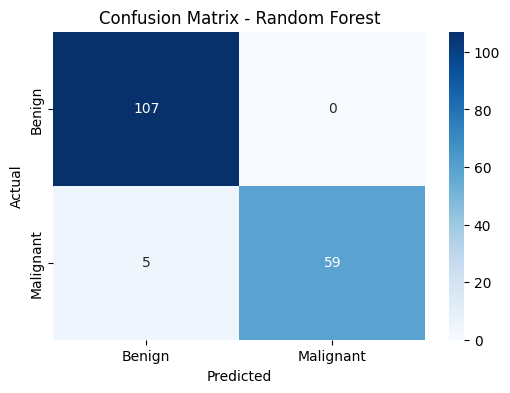


K-Nearest Neighbors Model:
Accuracy: 0.9649
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171

Confusion Matrix:
[[107   0]
 [  6  58]]


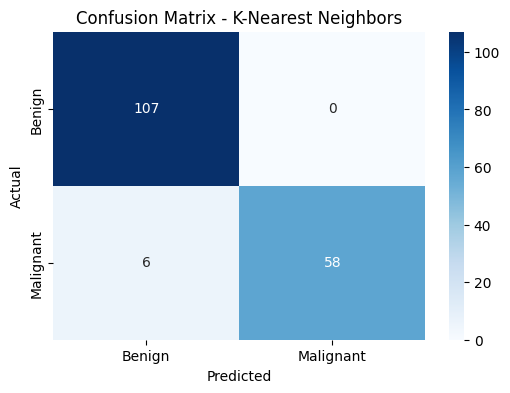


XGBoost Model:
Accuracy: 0.9883
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       107
           1       1.00      0.97      0.98        64

    accuracy                           0.99       171
   macro avg       0.99      0.98      0.99       171
weighted avg       0.99      0.99      0.99       171

Confusion Matrix:
[[107   0]
 [  2  62]]


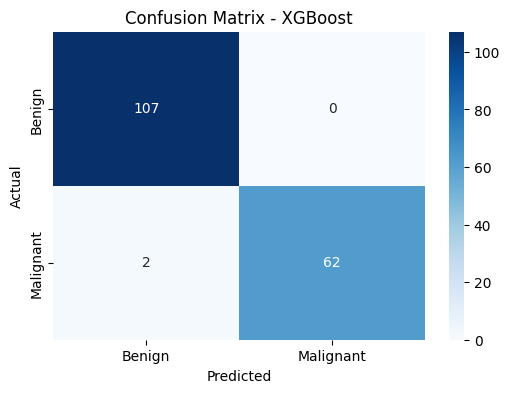


🏆 The model with the highest accuracy is: XGBoost with accuracy 0.9883


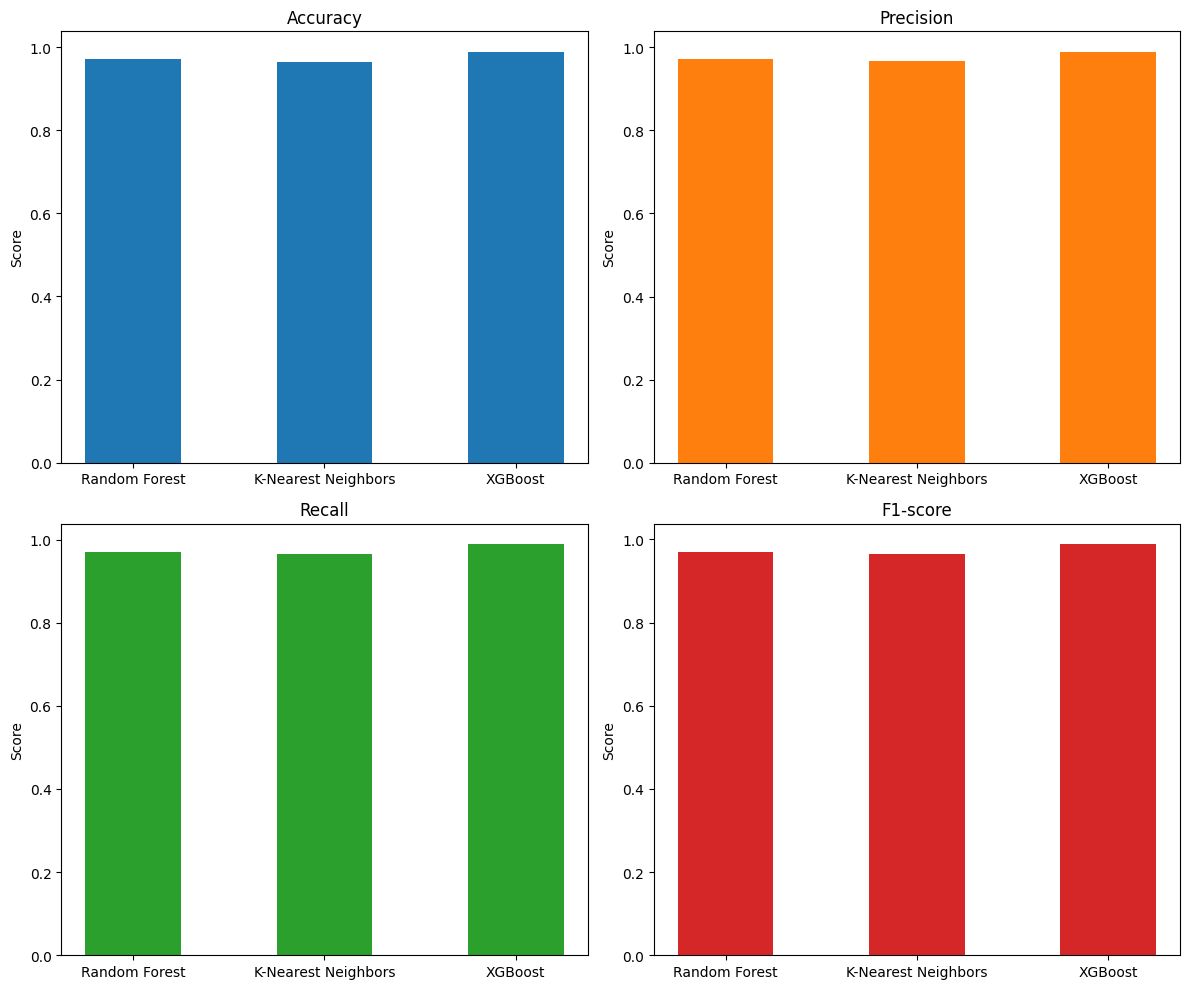

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
file_path = "/content/Breast_Cancer_Dataset.csv"
df = pd.read_csv(file_path)

# Drop unnecessary columns if they exist
if 'id' in df.columns:
    df = df.drop(columns=['id'])
if 'Unnamed: 32' in df.columns:
    df = df.drop(columns=['Unnamed: 32'])

# Handle missing values
df = df.dropna()

# Encode the 'diagnosis' column (M -> 1, B -> 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Feature Scaling (Standardization)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:])
df_scaled.insert(0, 'diagnosis', df['diagnosis'])  # Keep 'diagnosis' in the first column

# Split the data into training (70%) and testing (30%)
X = df_scaled.drop(columns=['diagnosis'])  # Features
y = df_scaled['diagnosis']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split training data for XGBoost early stopping
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# Hyperparameter Tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, n_jobs=-1, verbose=0)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Hyperparameter Tuning for KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1, verbose=0)
knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_

# Initialize Models with Tuned Hyperparameters
models = {
    "Random Forest": best_rf,
    "K-Nearest Neighbors": best_knn,
    "XGBoost": XGBClassifier(
        eval_metric='logloss', n_estimators=1000, learning_rate=0.01, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, early_stopping_rounds=20
    )
}

# Store results
results = {}
conf_matrices = {}

for name, model in models.items():
    if name == "XGBoost":
        model.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=False)
    else:
        model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    results[name] = {
        "accuracy": accuracy,
        "precision": report['weighted avg']['precision'],
        "recall": report['weighted avg']['recall'],
        "f1-score": report['weighted avg']['f1-score']
    }

    # Print results
    print(f"\n{name} Model:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{conf_matrices[name]}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrices[name], annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Identify Best Model
best_model = max(results, key=lambda k: results[k]["accuracy"])
print(f"\n🏆 The model with the highest accuracy is: {best_model} with accuracy {results[best_model]['accuracy']:.4f}")

# Plot comparison of accuracy, precision, recall, and F1-score
metrics = ["accuracy", "precision", "recall", "f1-score"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
x_labels = list(results.keys())  # Model names
x = np.arange(len(x_labels))  # X-axis positions
width = 0.2

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results]
    axes[i].bar(x, values, color=colors[i], width=0.5)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(x_labels)
    axes[i].set_title(metric.capitalize())
    axes[i].set_ylabel("Score")

plt.tight_layout()
plt.show()


Random Forest Model:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        21

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

Confusion Matrix:
[[36  0]
 [ 0 21]]


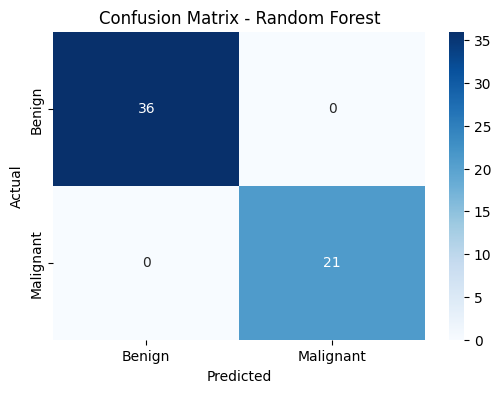


K-Nearest Neighbors Model:
Accuracy: 0.9298
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.95      0.86      0.90        21

    accuracy                           0.93        57
   macro avg       0.93      0.91      0.92        57
weighted avg       0.93      0.93      0.93        57

Confusion Matrix:
[[35  1]
 [ 3 18]]


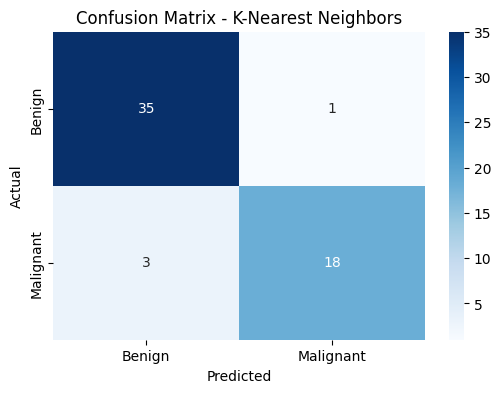


XGBoost Model:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        21

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

Confusion Matrix:
[[36  0]
 [ 0 21]]


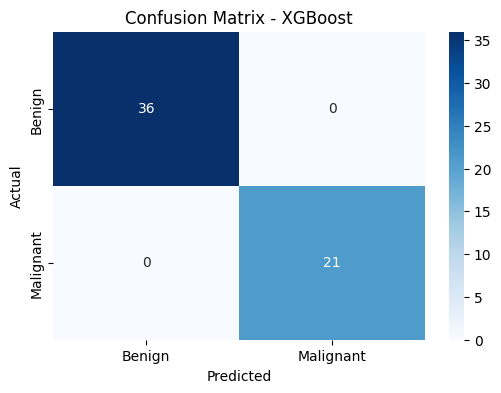


🏆 The model with the highest accuracy is: Random Forest with accuracy 1.0000


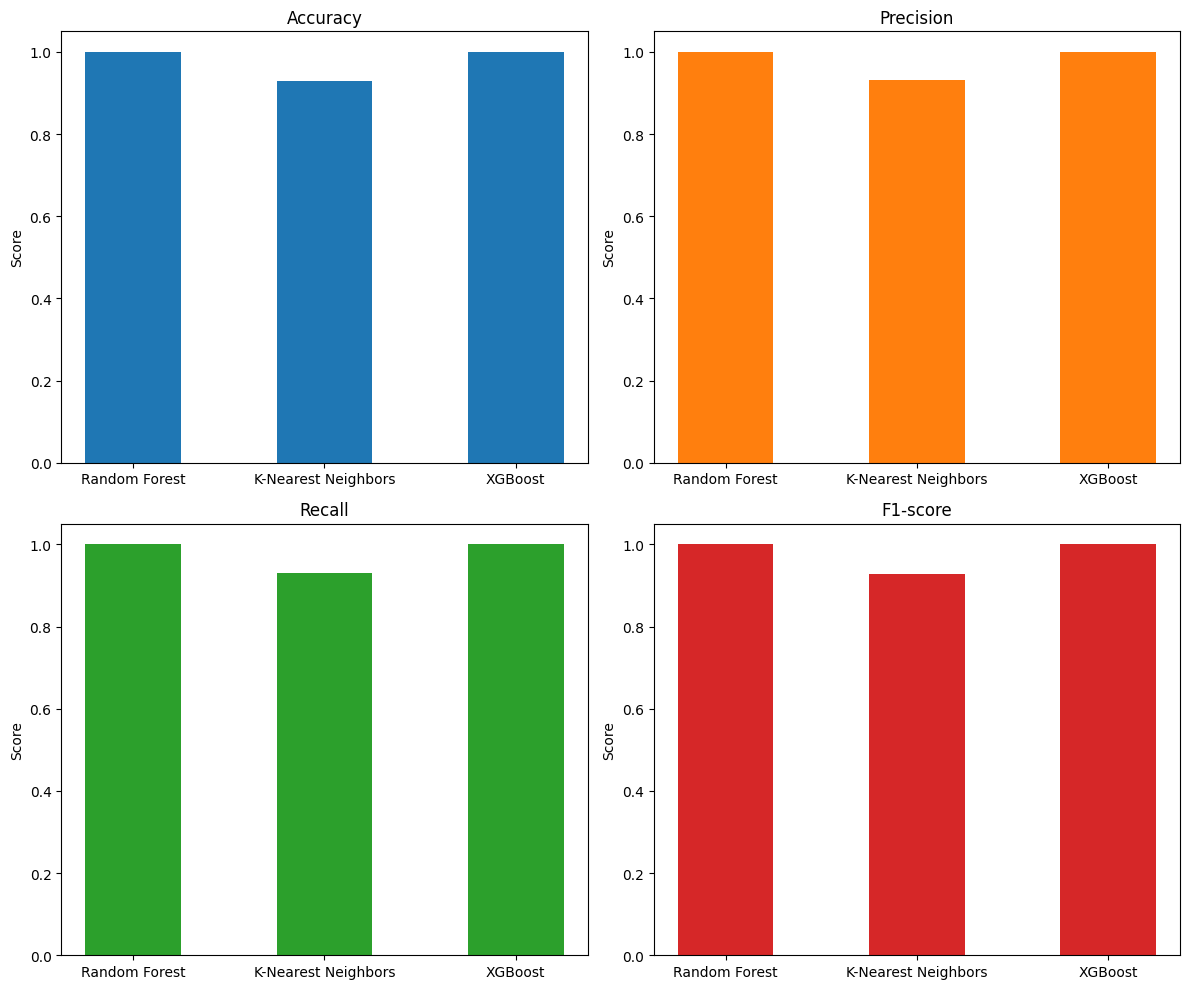

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
file_path = "Breast_Cancer_Dataset.csv"
df = pd.read_csv(file_path)

# Drop unnecessary columns if they exist
if 'id' in df.columns:
    df = df.drop(columns=['id'])
if 'Unnamed: 32' in df.columns:
    df = df.drop(columns=['Unnamed: 32'])

# Handle missing values
df = df.dropna()

# Encode the 'diagnosis' column (M -> 1, B -> 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Feature Scaling (Standardization)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:])
df_scaled.insert(0, 'diagnosis', df['diagnosis'])  # Keep 'diagnosis' in the first column

# Split the data into training (90%) and testing (10%)
X = df_scaled.drop(columns=['diagnosis'])  # Features
y = df_scaled['diagnosis']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Further split training data for XGBoost early stopping
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# Hyperparameter Tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, n_jobs=-1, verbose=0)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Hyperparameter Tuning for KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1, verbose=0)
knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_

# Initialize Models with Tuned Hyperparameters
models = {
    "Random Forest": best_rf,
    "K-Nearest Neighbors": best_knn,
    "XGBoost": XGBClassifier(
        eval_metric='logloss', n_estimators=1000, learning_rate=0.01, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, early_stopping_rounds=20
    )
}

# Store results
results = {}
conf_matrices = {}

for name, model in models.items():
    if name == "XGBoost":
        model.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=False)
    else:
        model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    results[name] = {
        "accuracy": accuracy,
        "precision": report['weighted avg']['precision'],
        "recall": report['weighted avg']['recall'],
        "f1-score": report['weighted avg']['f1-score']
    }

    # Print results
    print(f"\n{name} Model:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{conf_matrices[name]}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrices[name], annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Identify Best Model
best_model = max(results, key=lambda k: results[k]["accuracy"])
print(f"\n🏆 The model with the highest accuracy is: {best_model} with accuracy {results[best_model]['accuracy']:.4f}")

# Plot comparison of accuracy, precision, recall, and F1-score
metrics = ["accuracy", "precision", "recall", "f1-score"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
x_labels = list(results.keys())  # Model names
x = np.arange(len(x_labels))  # X-axis positions
width = 0.2

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results]
    axes[i].bar(x, values, color=colors[i], width=0.5)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(x_labels)
    axes[i].set_title(metric.capitalize())
    axes[i].set_ylabel("Score")

plt.tight_layout()
plt.show()


Random Forest Model:
Accuracy: 0.9737
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
[[72  0]
 [ 3 39]]


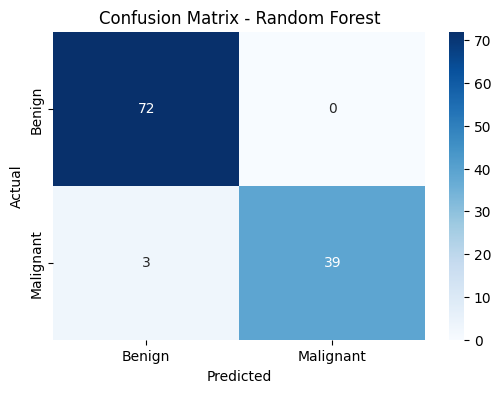


K-Nearest Neighbors Model:
Accuracy: 0.9386
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

Confusion Matrix:
[[71  1]
 [ 6 36]]


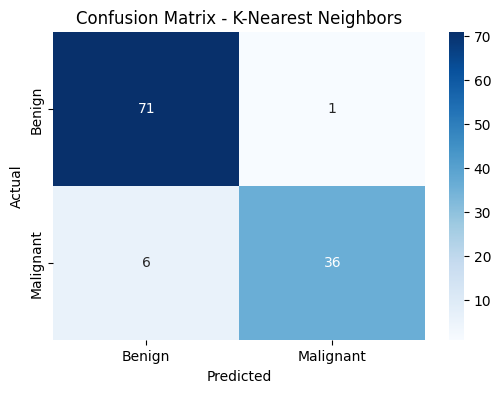


XGBoost Model:
Accuracy: 0.9825
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion Matrix:
[[72  0]
 [ 2 40]]


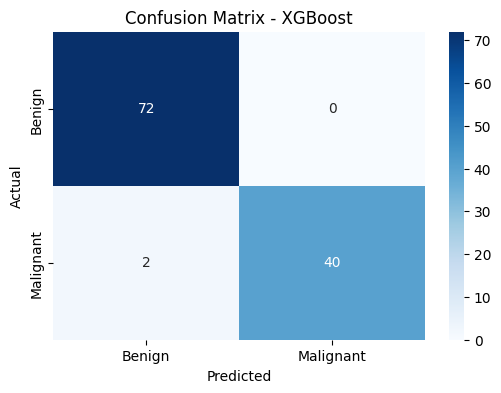


🏆 The model with the highest accuracy is: XGBoost with accuracy 0.9825


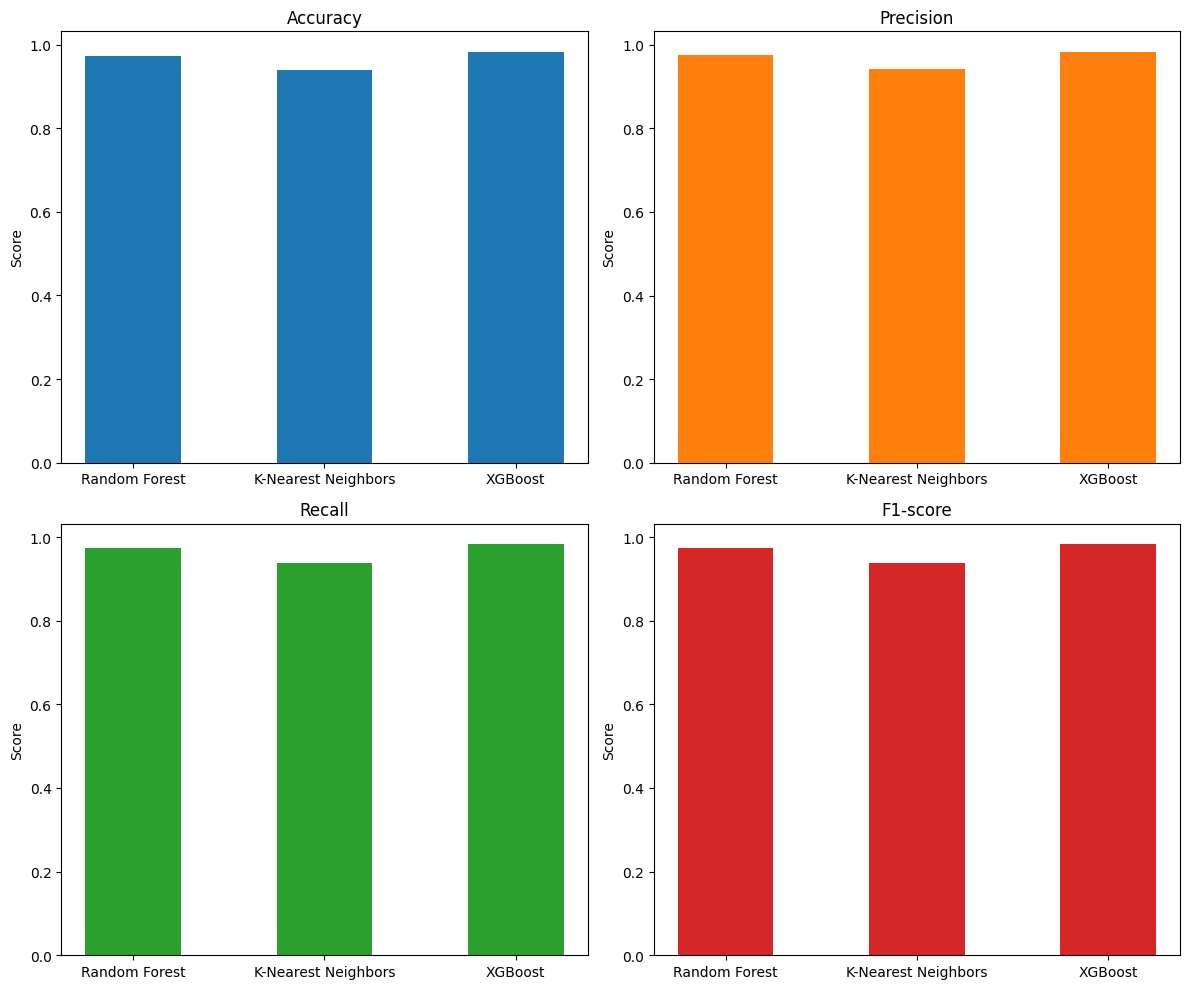

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
file_path = "Breast_Cancer_Dataset.csv"
df = pd.read_csv(file_path)

# Drop unnecessary columns if they exist
if 'id' in df.columns:
    df = df.drop(columns=['id'])
if 'Unnamed: 32' in df.columns:
    df = df.drop(columns=['Unnamed: 32'])

# Handle missing values
df = df.dropna()

# Encode the 'diagnosis' column (M -> 1, B -> 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Feature Scaling (Standardization)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:])
df_scaled.insert(0, 'diagnosis', df['diagnosis'])  # Keep 'diagnosis' in the first column

# Split the data into training (80%) and testing (20%)
X = df_scaled.drop(columns=['diagnosis'])  # Features
y = df_scaled['diagnosis']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split training data for XGBoost early stopping
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# Hyperparameter Tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, n_jobs=-1, verbose=0)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Hyperparameter Tuning for KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1, verbose=0)
knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_

# Initialize Models with Tuned Hyperparameters
models = {
    "Random Forest": best_rf,
    "K-Nearest Neighbors": best_knn,
    "XGBoost": XGBClassifier(
        eval_metric='logloss', n_estimators=1000, learning_rate=0.01, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, early_stopping_rounds=20
    )
}

# Store results
results = {}
conf_matrices = {}

for name, model in models.items():
    if name == "XGBoost":
        model.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=False)
    else:
        model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    results[name] = {
        "accuracy": accuracy,
        "precision": report['weighted avg']['precision'],
        "recall": report['weighted avg']['recall'],
        "f1-score": report['weighted avg']['f1-score']
    }

    # Print results
    print(f"\n{name} Model:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{conf_matrices[name]}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrices[name], annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Identify Best Model
best_model = max(results, key=lambda k: results[k]["accuracy"])
print(f"\n🏆 The model with the highest accuracy is: {best_model} with accuracy {results[best_model]['accuracy']:.4f}")

# Plot comparison of accuracy, precision, recall, and F1-score
metrics = ["accuracy", "precision", "recall", "f1-score"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
x_labels = list(results.keys())  # Model names
x = np.arange(len(x_labels))  # X-axis positions
width = 0.2

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results]
    axes[i].bar(x, values, color=colors[i], width=0.5)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(x_labels)
    axes[i].set_title(metric.capitalize())
    axes[i].set_ylabel("Score")

plt.tight_layout()
plt.show()
